# Hyperparameter Tuning
*(Note: This notebook runs significantly faster if you have access to a GPU. Use either the GPUHub, Google Colab, or your own GPU.)*

In this project, you will optimize the hyperparameters of a model in 3 stages.

## Paraphrase Detection
We finetune [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) on [MRPC](https://huggingface.co/datasets/glue/viewer/mrpc/train), a paraphrase detection dataset. This notebook is adapted from a [PyTorch Lightning example](https://lightning.ai/docs/pytorch/1.9.5/notebooks/lightning_examples/text-transformers.html).

In [ ]:
%pip install -q torch transformers lightning datasets wandb evaluate ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.0 MB/s eta 0:00:00


In [ ]:
!pip install -q "transformers==4.46.2" "accelerate>=0.34.0" "torch>=2.2.0" "datasets>=3.0.1" "evaluate>=0.4.3"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 70.0 MB/s eta 0:00:00


The next 4 cells are:
* Imports
* The `GLUEDataModule` loads the task's dataset and creates dataloaders for the train and valid sets.
* The `GLUETransformer` implements the model forward pass and the training/validation steps. You can check here what is logged with the `self.log` calls.
* The last cell runs training with the given parameters.

In [ ]:
from datetime import datetime
from typing import Optional

import datasets
import evaluate
import lightning as L
import torch
from torch.utils.data import DataLoader
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

In [ ]:
class GLUEDataModule(L.LightningDataModule):
    task_text_field_map = {
        "cola": ["sentence"],
        "sst2": ["sentence"],
        "mrpc": ["sentence1", "sentence2"],
        "qqp": ["question1", "question2"],
        "stsb": ["sentence1", "sentence2"],
        "mnli": ["premise", "hypothesis"],
        "qnli": ["question", "sentence"],
        "rte": ["sentence1", "sentence2"],
        "wnli": ["sentence1", "sentence2"],
        "ax": ["premise", "hypothesis"],
    }

    glue_task_num_labels = {
        "cola": 2,
        "sst2": 2,
        "mrpc": 2,
        "qqp": 2,
        "stsb": 1,
        "mnli": 3,
        "qnli": 2,
        "rte": 2,
        "wnli": 2,
        "ax": 3,
    }

    loader_columns = [
        "datasets_idx",
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "start_positions",
        "end_positions",
        "labels",
    ]

    def __init__(
        self,
        model_name_or_path: str,
        task_name: str = "mrpc",
        max_seq_length: int = 128,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        **kwargs,
    ):
        super().__init__()
        self.model_name_or_path = model_name_or_path
        self.task_name = task_name
        self.max_seq_length = max_seq_length
        self.train_batch_size = train_batch_size
        self.eval_batch_size = eval_batch_size

        self.text_fields = self.task_text_field_map[task_name]
        self.num_labels = self.glue_task_num_labels[task_name]
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def setup(self, stage: str):
        self.dataset = datasets.load_dataset("glue", self.task_name)

        for split in self.dataset.keys():
            self.dataset[split] = self.dataset[split].map(
                self.convert_to_features,
                batched=True,
                remove_columns=["label"],
            )
            self.columns = [c for c in self.dataset[split].column_names if c in self.loader_columns]
            self.dataset[split].set_format(type="torch", columns=self.columns)

        self.eval_splits = [x for x in self.dataset.keys() if "validation" in x]

    def prepare_data(self):
        datasets.load_dataset("glue", self.task_name)
        AutoTokenizer.from_pretrained(self.model_name_or_path, use_fast=True)

    def train_dataloader(self):
        return DataLoader(self.dataset["train"], batch_size=self.train_batch_size, shuffle=True)

    def val_dataloader(self):
        if len(self.eval_splits) == 1:
            return DataLoader(self.dataset["validation"], batch_size=self.eval_batch_size)
        elif len(self.eval_splits) > 1:
            return [DataLoader(self.dataset[x], batch_size=self.eval_batch_size) for x in self.eval_splits]

    def test_dataloader(self):
        if len(self.eval_splits) == 1:
            return DataLoader(self.dataset["test"], batch_size=self.eval_batch_size)
        elif len(self.eval_splits) > 1:
            return [DataLoader(self.dataset[x], batch_size=self.eval_batch_size) for x in self.eval_splits]

    def convert_to_features(self, example_batch, indices=None):
        # Either encode single sentence or sentence pairs
        if len(self.text_fields) > 1:
            texts_or_text_pairs = list(zip(example_batch[self.text_fields[0]], example_batch[self.text_fields[1]]))
        else:
            texts_or_text_pairs = example_batch[self.text_fields[0]]

        # Tokenize the text/text pairs
        features = self.tokenizer.batch_encode_plus(
            texts_or_text_pairs, max_length=self.max_seq_length, padding="max_length", truncation=True
        )

        # Rename label to labels to make it easier to pass to model forward
        features["labels"] = example_batch["label"]

        return features

In [ ]:
class GLUETransformer(L.LightningModule):
    def __init__(
        self,
        model_name_or_path: str,
        num_labels: int,
        task_name: str,
        learning_rate: float = 2e-5,
        warmup_steps: int = 0,
        weight_decay: float = 0.0,
        train_batch_size: int = 32,
        eval_batch_size: int = 32,
        eval_splits: Optional[list] = None,
        **kwargs,
    ):
        super().__init__()

        self.save_hyperparameters()

        self.config = AutoConfig.from_pretrained(model_name_or_path, num_labels=num_labels)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, config=self.config)
        self.metric = evaluate.load(
            "glue", self.hparams.task_name, experiment_id=datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
        )

        self.validation_step_outputs = []

    def forward(self, **inputs):
        return self.model(**inputs)

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs[0]
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
        outputs = self(**batch)
        val_loss, logits = outputs[:2]

        if self.hparams.num_labels > 1:
            preds = torch.argmax(logits, axis=1)
        elif self.hparams.num_labels == 1:
            preds = logits.squeeze()

        labels = batch["labels"]
        self.validation_step_outputs.append({"loss": val_loss, "preds": preds, "labels": labels})
        return val_loss

    def on_validation_epoch_end(self):
        if self.hparams.task_name == "mnli":
            for i, output in enumerate(self.validation_step_outputs):
                # matched or mismatched
                split = self.hparams.eval_splits[i].split("_")[-1]
                preds = torch.cat([x["preds"] for x in output]).detach().cpu().numpy()
                labels = torch.cat([x["labels"] for x in output]).detach().cpu().numpy()
                loss = torch.stack([x["loss"] for x in output]).mean()
                self.log(f"val_loss_{split}", loss, prog_bar=True)
                split_metrics = {
                    f"{k}_{split}": v for k, v in self.metric.compute(predictions=preds, references=labels).items()
                }
                self.log_dict(split_metrics, prog_bar=True)
            self.validation_step_outputs.clear()
            return loss

        preds = torch.cat([x["preds"] for x in self.validation_step_outputs]).detach().cpu().numpy()
        labels = torch.cat([x["labels"] for x in self.validation_step_outputs]).detach().cpu().numpy()
        loss = torch.stack([x["loss"] for x in self.validation_step_outputs]).mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log_dict(self.metric.compute(predictions=preds, references=labels), prog_bar=True)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.trainer.estimated_stepping_batches,
        )
        scheduler = {"scheduler": scheduler, "interval": "step", "frequency": 1}
        return [optimizer], [scheduler]


In [ ]:
epochs = 3  # do not change this
logger = False  # use your experiment tracking tool's logger

L.seed_everything(42)

dm = GLUEDataModule(
    model_name_or_path="distilbert-base-uncased",
    task_name="mrpc",
)
dm.setup("fit")
model = GLUETransformer(
    model_name_or_path="distilbert-base-uncased",
    num_labels=dm.num_labels,
    eval_splits=dm.eval_splits,
    task_name=dm.task_name,
)

trainer = L.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    devices=1,
    logger=logger,
)
trainer.fit(model, datamodule=dm)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

mrpc/train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

mrpc/validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

mrpc/test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name  | Type                                | Params | Mode
---------------------------------------------------------------------
0 | model | DistilBertForSequenceClassification | 67.0 M | eval
---------------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
0         Modules in train mode
96        Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type                                | Params | Mode
---------------------------------------------------------------------
0 | model | DistilBertForSequenceCla

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/loops/fit_loop.py:527: Found 96 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


### Week 1 task:


*   10 Hyperparameters
*   3 most promising hyperparameters to tune
*   adjusted optimizer



In [ ]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
default_config = {
    "optimizer_type": "adamw_torch",
    "lr_scheduler_type": "linear",
    "per_device_train_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "adam_beta1": 0.9,
    "adam_beta2": 0.999,
    "classifier_dropout": 0.1,
}


In [ ]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, AutoConfig
)
from datasets import load_dataset
import numpy as np
import evaluate
import torch
import wandb

wandb.login()

PROJECT_NAME = "MLOPS_p1_distilbert"  # <-- rename here


metric = evaluate.load("glue", "mrpc")

def make_run_name(cfg):
    name_parts = []
    for key, value in cfg.items():
        if key in ["learning_rate", "weight_decay", "lr_scheduler_type", "optimizer_type"]:
            name_parts.append(f"{key}-{value}")
    return "_".join(name_parts)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

def train_model(config=None):
    # Ensure config is accessible by both key and attribute
    if isinstance(config, dict):
        config_dict = config
    else:
        config_dict = dict(config)

    run_name = make_run_name(config_dict)

    with wandb.init(
        project=PROJECT_NAME,
        name=run_name,
        config=config_dict
    ) as run:

        config = wandb.config  # use wandb's config object

        # --- Load data ---
        dataset = load_dataset("glue", "mrpc")
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

        def preprocess_function(examples):
            return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True)
        encoded_dataset = dataset.map(preprocess_function, batched=True)

        # --- Model setup ---
        model_config = AutoConfig.from_pretrained("distilbert-base-uncased")
        model_config.num_labels = 2
        model_config.hidden_dropout_prob = config_dict["classifier_dropout"]

        model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            config=model_config,
        )

        # --- Training args ---
        args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            save_strategy="no",
            learning_rate=config_dict["learning_rate"],
            weight_decay=config_dict["weight_decay"],
            per_device_train_batch_size=config_dict["per_device_train_batch_size"],
            gradient_accumulation_steps=config_dict["gradient_accumulation_steps"],
            num_train_epochs=3,
            lr_scheduler_type=config_dict["lr_scheduler_type"],
            warmup_ratio=config_dict["warmup_ratio"],
            optim=config_dict["optimizer_type"],
            logging_steps=50,
            report_to="wandb",
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=encoded_dataset["train"],
            eval_dataset=encoded_dataset["validation"],
            compute_metrics=lambda p: evaluate.load("glue", "mrpc").compute(
                predictions=np.argmax(p.predictions, axis=-1),
                references=p.label_ids,
            ),
            tokenizer=tokenizer,
        )

        trainer.train()
        eval_results = trainer.evaluate()
        wandb.log(eval_results)


In [ ]:
sweep_configs = [
    {"learning_rate": lr, "weight_decay": wd, "warmup_ratio": wr}
    for lr in [1e-5, 2e-5, 3e-5, 5e-5]
    for wd in [0.0, 0.01, 0.05, 0.1]
    for wr in [0.0, 0.05, 0.1, 0.2]
]

for cfg in sweep_configs:
    full_cfg = default_config.copy()
    full_cfg.update(cfg)
    train_model(full_cfg)


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1875782143.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.553800,0.493579,0.715686,0.822630
2,0.446600,0.407299,0.823529,0.872792
3,0.348000,0.399268,0.825980,0.876522


epoch,▁
eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▁
eval/runtime,▆▁▆█
eval/samples_per_second,▃█▃▁
eval/steps_per_second,▃█▃▁
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1875782143.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.491900,0.380277,0.850490,0.890090
2,0.359500,0.371974,0.843137,0.893333
3,0.193600,0.473730,0.840686,0.891122


epoch,▁
eval/accuracy,█▃▁▁
eval/f1,▁█▃▃
eval/loss,▂▁██
eval/runtime,█▁▆▃
eval/samples_per_second,▁█▃▆
eval/steps_per_second,▁█▃▆
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1875782143.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instea

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.460800,0.395045,0.813725,0.867596
2,0.334400,0.428057,0.848039,0.897351
3,0.157100,0.523770,0.843137,0.890785


epoch,▁
eval/accuracy,▁█▇▇
eval/f1,▁█▆▆
eval/loss,▁▃██
eval/runtime,█▁▅▁
eval/samples_per_second,▁█▄█
eval/steps_per_second,▁█▄█
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1875782143.py:87: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.524800,0.407679,0.830882,0.877005
2,0.399200,0.350501,0.835784,0.884682
3,0.251700,0.379976,0.843137,0.891892


epoch,▁
eval/accuracy,▁▄██
eval/f1,▁▅██
eval/loss,█▁▅▅
eval/runtime,█▁▅▂
eval/samples_per_second,▁█▄▇
eval/steps_per_second,▁█▄▇
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


# Week 2 - Optimize model manually

In [ ]:
# ============================================
# 📘 MLOps Project 1 — DistilBERT MRPC Tuning
# Week 2+ setup (supports Bonus Task)
# ============================================

!pip install -q transformers datasets evaluate wandb

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, AutoConfig
)
from datasets import load_dataset
import numpy as np
import evaluate
import torch
import wandb
import random
from pathlib import Path
import matplotlib.pyplot as plt

# --- Initialize Weights & Biases ---
wandb.login()
PROJECT_NAME = "MLOPS_p1_distilbert"

# --- Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Metric ---
metric = evaluate.load("glue", "mrpc")

# --- Short, descriptive run name ---
def make_run_name(cfg):
    """Generate concise run name with key hyperparameters."""
    return f"lr{cfg['learning_rate']}_wd{cfg['weight_decay']}_wr{cfg['warmup_ratio']}"

# --- Metric computation for Trainer ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

# --- Training Function ---
def train_model(config=None):
    """Train DistilBERT on MRPC with given hyperparameters."""
    # Normalize config object
    config_dict = dict(config) if not isinstance(config, dict) else config

    # Generate descriptive run name
    run_name = make_run_name(config_dict)

    with wandb.init(project=PROJECT_NAME, name=run_name, config=config_dict):
        config = wandb.config

        # --- Load data ---
        dataset = load_dataset("glue", "mrpc")
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

        def preprocess_function(examples):
            return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True)
        encoded_dataset = dataset.map(preprocess_function, batched=True)

        # --- Model setup ---
        model_config = AutoConfig.from_pretrained("distilbert-base-uncased")
        model_config.num_labels = 2
        model_config.hidden_dropout_prob = config_dict["classifier_dropout"]

        model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            config=model_config,
        )

        # --- Training Arguments ---
        args = TrainingArguments(
            output_dir="./results",
            evaluation_strategy="epoch",
            save_strategy="epoch",  # Save each epoch for Bonus Task plots
            save_total_limit=1,
            learning_rate=config_dict["learning_rate"],
            weight_decay=config_dict["weight_decay"],
            per_device_train_batch_size=config_dict["per_device_train_batch_size"],
            gradient_accumulation_steps=config_dict["gradient_accumulation_steps"],
            num_train_epochs=3,
            lr_scheduler_type=config_dict["lr_scheduler_type"],
            warmup_ratio=config_dict["warmup_ratio"],
            optim=config_dict["optimizer_type"],
            logging_steps=50,
            report_to="wandb",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
        )

        # --- Trainer ---
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=encoded_dataset["train"],
            eval_dataset=encoded_dataset["validation"],
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
        )

        # --- Train & Evaluate ---
        trainer.train()
        eval_results = trainer.evaluate()

        # Log final results
        wandb.log(eval_results)
        return eval_results

# ============================================
# Sweep Configuration for Week 2
# ============================================

default_config = {
    "optimizer_type": "adamw_torch",
    "lr_scheduler_type": "linear",
    "per_device_train_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "adam_beta1": 0.9,
    "adam_beta2": 0.999,
    "classifier_dropout": 0.1,
}

# Focused tuning on 3 hyperparameters
sweep_configs = [
    {"learning_rate": lr, "weight_decay": wd, "warmup_ratio": wr}
    for lr in [1e-5, 2e-5, 3e-5, 5e-5]
    for wd in [0.0, 0.01, 0.05, 0.1]
    for wr in [0.0, 0.05, 0.1, 0.2]
]

# Optional: Limit to 12 runs for Week 2
random.seed(42)
sweep_configs = random.sample(sweep_configs, 12)

# ============================================
# Run Experiments
# ============================================
Path("results").mkdir(exist_ok=True)

for cfg in sweep_configs:
    full_cfg = default_config.copy()
    full_cfg.update(cfg)
    train_model(full_cfg)

# ============================================
# 📊 Bonus Task: Comparison Plot (example)
# ============================================
# After all runs complete, you can download results via wandb API
# and plot validation accuracy vs. learning rate, etc.

# Example:
# api = wandb.Api()
# runs = api.runs(f"{wandb.api.default_entity}/{PROJECT_NAME}")
# accs = [(run.name, run.summary.get('eval_accuracy', 0)) for run in runs]
# accs_sorted = sorted(accs, key=lambda x: x[1], reverse=True)
# print("Top 5 runs:", accs_sorted[:5])


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.554100,0.493923,0.715686,0.822630
2,0.446800,0.407468,0.823529,0.872792
3,0.348200,0.399284,0.825980,0.876522


epoch,▁
eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▁
eval/runtime,▄▁█▅
eval/samples_per_second,▅█▁▄
eval/steps_per_second,▅█▁▄
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.552600,0.496146,0.710784,0.820122
2,0.457400,0.415227,0.823529,0.873239
3,0.365000,0.405533,0.833333,0.882353


epoch,▁
eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▂▁▁
eval/runtime,▁▁▃█
eval/samples_per_second,██▆▁
eval/steps_per_second,██▆▁
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.506500,0.437830,0.799020,0.850909
2,0.395600,0.345551,0.857843,0.901695
3,0.199400,0.404213,0.845588,0.893401


epoch,▁
eval/accuracy,▁█▇█
eval/f1,▁█▇█
eval/loss,█▁▅▁
eval/runtime,▇▁▆█
eval/samples_per_second,▂█▃▁
eval/steps_per_second,▂█▃▁
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.511800,0.416114,0.828431,0.874552
2,0.396400,0.355970,0.838235,0.887372
3,0.250200,0.386271,0.848039,0.894915


epoch,▁
eval/accuracy,▁▅██
eval/f1,▁▅██
eval/loss,█▁▅▅
eval/runtime,▅▁█▄
eval/samples_per_second,▄█▁▅
eval/steps_per_second,▄█▁▅
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.572500,0.517617,0.703431,0.817496
2,0.467000,0.426979,0.806373,0.859180
3,0.371600,0.414204,0.828431,0.878472


epoch,▁
eval/accuracy,▁▇██
eval/f1,▁▆██
eval/loss,█▂▁▁
eval/runtime,▇▁█▆
eval/samples_per_second,▂█▁▃
eval/steps_per_second,▂█▁▃
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.489600,0.391326,0.830882,0.876122
2,0.342100,0.428385,0.833333,0.888158
3,0.152400,0.578300,0.835784,0.887395


epoch,▁
eval/accuracy,▁▄██
eval/f1,▁███
eval/loss,▁▂██
eval/runtime,▃▁█▃
eval/samples_per_second,▆█▁▆
eval/steps_per_second,▅█▁▆
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.554000,0.501429,0.705882,0.817629
2,0.461700,0.423819,0.821078,0.871252
3,0.376800,0.412919,0.818627,0.872852


epoch,▁
eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▂
eval/runtime,▂▁▂█
eval/samples_per_second,▇█▆▁
eval/steps_per_second,▇█▆▁
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.460700,0.387247,0.843137,0.891525
2,0.331500,0.388044,0.855392,0.901173
3,0.165200,0.464832,0.857843,0.900685


epoch,▁
eval/accuracy,▁▇██
eval/f1,▁███
eval/loss,▁▁██
eval/runtime,▅▁█▃
eval/samples_per_second,▃█▁▆
eval/steps_per_second,▃█▁▆
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.560000,0.504744,0.710784,0.821752
2,0.460600,0.421003,0.823529,0.873239
3,0.369000,0.412177,0.825980,0.876950


epoch,▁
eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▂▁▁
eval/runtime,█▁▆▇
eval/samples_per_second,▁█▃▂
eval/steps_per_second,▁█▃▂
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.506300,0.437736,0.799020,0.850909
2,0.393800,0.351476,0.843137,0.892617
3,0.189200,0.421268,0.852941,0.898305


epoch,▁
eval/accuracy,▁▇██
eval/f1,▁▇██
eval/loss,█▁▇▇
eval/runtime,▅▁▇█
eval/samples_per_second,▄█▂▁
eval/steps_per_second,▄█▂▁
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.462500,0.348307,0.845588,0.888889
2,0.323400,0.432063,0.833333,0.886288
3,0.150500,0.560942,0.830882,0.883642


epoch,▁
eval/accuracy,█▂▁█
eval/f1,█▅▁█
eval/loss,▁▄█▁
eval/runtime,█▆▁▃
eval/samples_per_second,▁▃█▆
eval/steps_per_second,▁▃█▆
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.491100,0.381093,0.843137,0.884477
2,0.359600,0.374082,0.843137,0.893333
3,0.194500,0.470152,0.843137,0.892617


epoch,▁
eval/accuracy,▁▁▁▁
eval/f1,▁█▇▁
eval/loss,▂▁█▂
eval/runtime,▆▁█▆
eval/samples_per_second,▃█▁▃
eval/steps_per_second,▃█▁▃
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...


### Manual Model optimization

*   first i wrote all result metrics to a csv file.
*   acorrding to this information we gave claude to manually choose the optimal hyperparameter values for learning_rate, weight_decay and warmup_ratio
*   we let the model initialize another run



In [ ]:
import wandb
import pandas as pd

def inspect_run_details(entity, project_name, num_runs=2):
    """
    Deep inspection of run structure to find where metrics are stored.
    """
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project_name}")

    print(f"Total runs in project: {len(runs)}\n")

    for i, run in enumerate(runs):
        if i >= num_runs:
            break

        print("="*80)
        print(f"RUN {i+1}: {run.name}")
        print(f"ID: {run.id}")
        print(f"State: {run.state}")
        print(f"Created: {run.created_at}")
        print("="*80)

        print("\n--- CONFIG ---")
        print(f"Type: {type(run.config)}")
        if hasattr(run.config, '__dict__'):
            print("Config attributes:", dir(run.config))
        try:
            config_dict = dict(run.config) if hasattr(run.config, '__iter__') else {}
            for key, val in config_dict.items():
                if not key.startswith('_'):
                    print(f"  {key}: {val}")
        except:
            print("  Could not extract config")

        print("\n--- SUMMARY ---")
        print(f"Type: {type(run.summary)}")
        if hasattr(run.summary, '__dict__'):
            print("Summary attributes:", [a for a in dir(run.summary) if not a.startswith('_')])

        try:
            if hasattr(run.summary, '_json_dict'):
                print("\nSummary _json_dict:")
                for key, val in run.summary._json_dict.items():
                    print(f"  {key}: {val}")
        except:
            pass

        try:
            if hasattr(run.summary, 'keys'):
                summary_keys = list(run.summary.keys())
                print(f"\nSummary keys: {summary_keys}")
        except:
            pass

        print("\n--- HISTORY (last 5 logged steps) ---")
        try:
            history = run.history(samples=5)
            print(f"History shape: {history.shape}")
            print(f"History columns: {list(history.columns)}")
            print("\nLast 5 rows:")
            print(history)
        except Exception as e:
            print(f"Could not get history: {e}")

        print("\n\n")


def get_all_runs_with_history(entity, project_name):
    """
    Get final metrics from run history (more reliable than summary).
    """
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project_name}")

    data = []

    for run in runs:
        row = {
            "run_id": run.id,
            "run_name": run.name,
            "state": run.state,
        }

        try:
            config_dict = dict(run.config) if hasattr(run.config, '__iter__') else {}
            for key, val in config_dict.items():
                if not key.startswith('_'):
                    row[f"config_{key}"] = val
        except:
            pass

        try:
            history = run.history()
            if len(history) > 0:
                last_row = history.iloc[-1]

                for col in history.columns:
                    if not col.startswith('_'):
                        row[col] = last_row[col]
        except Exception as e:
            print(f"Warning: Could not get history for run {run.name}: {e}")

        data.append(row)

    return pd.DataFrame(data)


def get_metrics_summary(entity, project_name):
    """
    Extract key metrics focusing on eval metrics from final evaluation.
    """
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project_name}")

    data = []

    for run in runs:
        row = {
            "run_id": run.id,
            "run_name": run.name,
            "state": run.state,
        }

        try:
            config_dict = dict(run.config) if hasattr(run.config, '__iter__') else {}
            row["learning_rate"] = config_dict.get("learning_rate", None)
            row["weight_decay"] = config_dict.get("weight_decay", None)
            row["warmup_ratio"] = config_dict.get("warmup_ratio", None)
            row["classifier_dropout"] = config_dict.get("classifier_dropout", None)
            row["per_device_train_batch_size"] = config_dict.get("per_device_train_batch_size", None)
            row["optimizer_type"] = config_dict.get("optimizer_type", None)
        except:
            pass

        try:
            history = run.history()
            if len(history) > 0:
                eval_rows = history[history['eval_accuracy'].notna()]

                if len(eval_rows) > 0:
                    final_eval = eval_rows.iloc[-1]
                    row["eval_accuracy"] = final_eval.get("eval_accuracy", None)
                    row["eval_f1"] = final_eval.get("eval_f1", None)
                    row["eval_loss"] = final_eval.get("eval_loss", None)

                train_rows = history[history['train_loss'].notna()]
                if len(train_rows) > 0:
                    final_train = train_rows.iloc[-1]
                    row["final_train_loss"] = final_train.get("train_loss", None)
                    row["final_learning_rate"] = final_train.get("train_learning_rate", None)
                    row["final_grad_norm"] = final_train.get("train_grad_norm", None)
        except Exception as e:
            print(f"Warning: Could not process run {run.name}: {e}")

        data.append(row)

    df = pd.DataFrame(data)
    return df


if __name__ == "__main__":
    ENTITY = "janick-steffen-hslu"
    PROJECT = "MLOPS_p1_distilbert"

    print("STEP 1: Deep inspection of run structure")
    print("="*80)
    inspect_run_details(ENTITY, PROJECT, num_runs=1)

    print("\n\nSTEP 2: Get all metrics from history")
    print("="*80)
    df = get_metrics_summary(ENTITY, PROJECT)

    print(f"\nFound {len(df)} runs")
    print(f"\nColumns: {list(df.columns)}")

    print("\n\nAll runs sorted by eval_accuracy:")
    df_sorted = df.sort_values("eval_accuracy", ascending=False)

    cols_to_show = [c for c in [
        "run_name", "eval_accuracy", "eval_f1",
        "learning_rate", "weight_decay", "warmup_ratio"
    ] if c in df.columns]

    print(df_sorted[cols_to_show])

    df.to_csv("wandb_runs_summary.csv", index=False)
    print("\n\nExported to wandb_runs_summary.csv")

STEP 1: Deep inspection of run structure
Total runs in project: 30

RUN 1: lr1e-05_wd0.1_wr0.1
ID: kivtwkg9
State: finished
Created: 2025-10-12T16:36:15Z

--- CONFIG ---
Type: <class 'str'>
  Could not extract config

--- SUMMARY ---
Type: <class 'wandb.old.summary.HTTPSummary'>
Summary attributes: ['get', 'items', 'keys', 'load', 'open_h5', 'read_h5', 'update', 'write_h5']

Summary _json_dict:

--- HISTORY (last 5 logged steps) ---
History shape: (5, 21)
History columns: ['_step', 'eval/f1', 'train/grad_norm', 'train/global_step', 'eval/steps_per_second', 'eval_samples_per_second', 'eval_loss', 'eval_runtime', '_runtime', 'epoch', 'eval/runtime', 'eval/loss', 'eval_steps_per_second', 'eval/samples_per_second', 'eval_accuracy', 'train/loss', 'train/epoch', 'train/learning_rate', '_timestamp', 'eval/accuracy', 'eval_f1']

Last 5 rows:
   _step   eval/f1  train/grad_norm  train/global_step  eval/steps_per_second  \
0      4  0.822630              NaN                230                 50

### Optimized Config by Claude

In [ ]:
"""
Optimal Hyperparameter Configuration
Based on 12 manual tuning runs in Week 2

Analysis Summary:
- Learning Rate 3e-5: Best average performance (85.13%) and highest max (85.78%)
- Weight Decay 0.1: Good regularization, prevents overfitting
- Warmup Ratio 0.2: Stable training with gradual LR warmup

Best Result: 85.78% validation accuracy, 90.17% F1, 0.3456 loss
"""

# Use this configuration for your next training run
hyperparameter_config = {
    "learning_rate": 3e-5,
    "weight_decay": 0.1,
    "warmup_ratio": 0.2,
    "optimizer_type": "adamw_torch",
    "lr_scheduler_type": "linear",
    "per_device_train_batch_size": 16,
    "gradient_accumulation_steps": 1,
    "adam_beta1": 0.9,
    "adam_beta2": 0.999,
    "classifier_dropout": 0.1,
}

# Run this configuration
if __name__ == "__main__":
    # Initialize wandb
    wandb.login()

    # Train with optimal config
    print("Training with optimal hyperparameters...")
    print(f"LR: {optimal_config['learning_rate']}")
    print(f"Weight Decay: {optimal_config['weight_decay']}")
    print(f"Warmup Ratio: {optimal_config['warmup_ratio']}")

    results = train_model(optimal_config)
    print(f"\nResults: {results}")


# For further fine-tuning (Week 3 or bonus), explore around the optimum:
fine_tuning_ranges = {
    "learning_rate": [2.5e-5, 3e-5, 3.5e-5, 4e-5],
    "weight_decay": [0.08, 0.09, 0.1, 0.11, 0.12],
    "warmup_ratio": [0.15, 0.18, 0.2, 0.22, 0.25],
}

print("\nFor Week 3 automatic optimization, use these ranges:")
print(fine_tuning_ranges)

Training with optimal hyperparameters...
LR: 3e-05
Weight Decay: 0.1
Warmup Ratio: 0.2


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-1690421235.py:99: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.506500,0.437830,0.799020,0.850909
2,0.395600,0.345551,0.857843,0.901695
3,0.199400,0.404213,0.845588,0.893401


epoch,▁
eval/accuracy,▁█▇█
eval/f1,▁█▇█
eval/loss,█▁▅▁
eval/runtime,▇▁█▁
eval/samples_per_second,▂█▁█
eval/steps_per_second,▂█▁█
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
+8,...



Results: {'eval_loss': 0.3455509841442108, 'eval_accuracy': 0.8578431372549019, 'eval_f1': 0.9016949152542373, 'eval_runtime': 0.9904, 'eval_samples_per_second': 411.948, 'eval_steps_per_second': 51.493, 'epoch': 3.0}

For Week 3 automatic optimization, use these ranges:
{'learning_rate': [2.5e-05, 3e-05, 3.5e-05, 4e-05], 'weight_decay': [0.08, 0.09, 0.1, 0.11, 0.12], 'warmup_ratio': [0.15, 0.18, 0.2, 0.22, 0.25]}


# Week 3 - automated optimal config with Bayesian, grid and random search

In [ ]:
# ============================================
# MLOps Project 1 - Week 3: Automatic Hyperparameter Optimization
# Using Wandb Sweeps with Bayesian Optimization
# ============================================

# Run this first in Colab
# !pip install -q transformers datasets evaluate wandb

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, AutoConfig
)
from datasets import load_dataset
import numpy as np
import evaluate
import torch
import wandb
import random
from pathlib import Path

# --- Initialize Weights & Biases ---
wandb.login()
PROJECT_NAME = "MLOPS_p1_distilbert"

# --- Reproducibility ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# --- Metric ---
metric = evaluate.load("glue", "mrpc")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return metric.compute(predictions=preds, references=labels)

# --- Training Function for Sweep ---
def train_sweep():
    """
    Training function called by wandb sweep agent.
    Uses hyperparameters from wandb.config automatically.
    """
    # Create descriptive run name based on hyperparameters
    run_name = None

    with wandb.init() as run:
        config = wandb.config

        # Create descriptive run name similar to manual runs
        run_name = (f"lr{config.learning_rate:.0e}_"
                   f"wd{config.weight_decay}_"
                   f"wr{config.warmup_ratio}_"
                   f"sweep_bayesian")
        run.name = run_name

        set_seed(42)

        # --- Load data ---
        dataset = load_dataset("glue", "mrpc")
        tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

        def preprocess_function(examples):
            return tokenizer(examples["sentence1"], examples["sentence2"], truncation=True)

        encoded_dataset = dataset.map(preprocess_function, batched=True)

        # --- Model setup ---
        model_config = AutoConfig.from_pretrained("distilbert-base-uncased")
        model_config.num_labels = 2
        model_config.hidden_dropout_prob = config.classifier_dropout

        # Note: Warning about uninitialized weights is expected and normal
        # The classification head is randomly initialized and will be trained
        model = AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased",
            config=model_config,
        )

        # --- Training Arguments ---
        args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch",  # Updated from evaluation_strategy
            save_strategy="epoch",
            save_total_limit=1,
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            per_device_train_batch_size=config.per_device_train_batch_size,
            gradient_accumulation_steps=config.gradient_accumulation_steps,
            num_train_epochs=3,
            lr_scheduler_type=config.lr_scheduler_type,
            warmup_ratio=config.warmup_ratio,
            optim=config.optimizer_type,
            logging_steps=50,
            report_to="wandb",
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            seed=42,
            data_seed=42,
        )

        # --- Trainer ---
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=encoded_dataset["train"],
            eval_dataset=encoded_dataset["validation"],
            compute_metrics=compute_metrics,
            tokenizer=tokenizer,
        )

        # --- Train & Evaluate ---
        trainer.train()
        eval_results = trainer.evaluate()

        wandb.log({
            "final_eval_accuracy": eval_results["eval_accuracy"],
            "final_eval_f1": eval_results["eval_f1"],
            "final_eval_loss": eval_results["eval_loss"],
        })

# ============================================
# Sweep Configuration
# ============================================

sweep_config = {
    "name": "week3_bayesian_sweep",
    "method": "bayes",
    "metric": {
        "name": "eval_accuracy",
        "goal": "maximize"
    },
    "parameters": {
        # Focus on the 3 most important hyperparameters
        "learning_rate": {
            "distribution": "uniform",
            "min": 2.5e-5,
            "max": 4e-5
        },
        "weight_decay": {
            "distribution": "uniform",
            "min": 0.08,
            "max": 0.12
        },
        "warmup_ratio": {
            "distribution": "uniform",
            "min": 0.15,
            "max": 0.25
        },
        # Fixed parameters based on Week 2 findings
        "optimizer_type": {
            "value": "adamw_torch"
        },
        "lr_scheduler_type": {
            "value": "linear"
        },
        "per_device_train_batch_size": {
            "value": 16
        },
        "gradient_accumulation_steps": {
            "value": 1
        },
        "classifier_dropout": {
            "value": 0.1
        },
    }
}

# ============================================
# Initialize and Run Sweep
# ============================================

# Create sweep
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME)

print(f"Sweep ID: {sweep_id}")
print(f"Running 12 sweep runs with Bayesian optimization...")
print(f"Searching around optimal region:")
print(f"  Learning Rate: [2.5e-5, 4e-5]")
print(f"  Weight Decay: [0.08, 0.12]")
print(f"  Warmup Ratio: [0.15, 0.25]")

# Run sweep agent (12 runs)
wandb.agent(sweep_id, function=train_sweep, count=12)

print("\nSweep completed!")
print(f"View results at: https://wandb.ai/{wandb.api.default_entity}/{PROJECT_NAME}/sweeps/{sweep_id}")

Create sweep with ID: 425e5baw
Sweep URL: https://wandb.ai/janick-steffen-hslu/MLOPS_p1_distilbert/sweeps/425e5baw
Sweep ID: 425e5baw
Running 12 sweep runs with Bayesian optimization...
Searching around optimal region:
  Learning Rate: [2.5e-5, 4e-5]
  Weight Decay: [0.08, 0.12]
  Warmup Ratio: [0.15, 0.25]


wandb: Agent Starting Run: o5qapd30 with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.94249205049267e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.1912514998689288
wandb: 	weight_decay: 0.08077628487852258


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.478100,0.388095,0.828431,0.873646
2,0.351300,0.397755,0.838235,0.889632
3,0.180800,0.505658,0.850490,0.895726


eval/accuracy,▁▄██
eval/f1,▁▆██
eval/loss,▁▂██
eval/runtime,▂▁▄█
eval/samples_per_second,▇█▅▁
eval/steps_per_second,▇█▅▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: 2de9e7xl with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 2.7943967067336577e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.18432161451991363
wandb: 	weight_decay: 0.09626953003843262


Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.510000,0.400000,0.835784,0.883478
2,0.389700,0.360132,0.855392,0.901503
3,0.194800,0.408575,0.855392,0.899830


eval/accuracy,▁███
eval/f1,▁█▇█
eval/loss,▇▁█▁
eval/runtime,▆▁█▇
eval/samples_per_second,▃█▁▂
eval/steps_per_second,▃█▁▂
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: d5uipuon with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.940493483851003e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.20964201988804068
wandb: 	weight_decay: 0.08912560252873362


Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.488500,0.414640,0.828431,0.877193
2,0.352000,0.400963,0.838235,0.891447
3,0.188000,0.533482,0.852941,0.898990


eval/accuracy,▁▄██
eval/f1,▁▆██
eval/loss,▂▁██
eval/runtime,▁▁█▆
eval/samples_per_second,██▁▃
eval/steps_per_second,██▁▃
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: halc60je with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.050061718983099e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.1526640799711964
wandb: 	weight_decay: 0.08702100511475391


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.495300,0.391899,0.828431,0.876325
2,0.372400,0.370932,0.852941,0.899666
3,0.183100,0.466181,0.845588,0.893401


eval/accuracy,▁█▆█
eval/f1,▁█▆█
eval/loss,▃▁█▁
eval/runtime,▃▁▃█
eval/samples_per_second,▆█▆▁
eval/steps_per_second,▆█▆▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: 27j60vc2 with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.9936236664539533e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.24592862353657344
wandb: 	weight_decay: 0.08672084515409337


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.517700,0.391883,0.813725,0.861818
2,0.377200,0.374185,0.845588,0.894825
3,0.181500,0.478049,0.850490,0.896785


eval/accuracy,▁▇██
eval/f1,▁███
eval/loss,▂▁██
eval/runtime,▆▁▇█
eval/samples_per_second,▃█▂▁
eval/steps_per_second,▃█▂▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: 4zyh0pwp with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.3731654329040575e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.2204027672155748
wandb: 	weight_decay: 0.08680930765281449


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.519400,0.408472,0.818627,0.866426
2,0.388500,0.366522,0.855392,0.901830
3,0.187000,0.428058,0.850490,0.896082


eval/accuracy,▁█▇█
eval/f1,▁█▇█
eval/loss,▆▁█▁
eval/runtime,█▁█▆
eval/samples_per_second,▁█▁▃
eval/steps_per_second,▁█▁▃
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: 1dsyisrj with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.068216543957976e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.2457156886961324
wandb: 	weight_decay: 0.1105089007102162


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.522700,0.413219,0.823529,0.870968
2,0.390300,0.364645,0.857843,0.903333
3,0.194200,0.415868,0.848039,0.895623


eval/accuracy,▁█▆█
eval/f1,▁█▆█
eval/loss,█▁█▁
eval/runtime,▄▁▅█
eval/samples_per_second,▅█▄▁
eval/steps_per_second,▅█▄▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: smg4iptb with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 2.739732230866113e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.16821581688599577
wandb: 	weight_decay: 0.10869600092635412


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.504300,0.395103,0.835784,0.882662
2,0.390700,0.357473,0.855392,0.901173
3,0.197100,0.411634,0.852941,0.897959


eval/accuracy,▁█▇█
eval/f1,▁█▇█
eval/loss,▆▁█▁
eval/runtime,█▁█▇
eval/samples_per_second,▁█▁▂
eval/steps_per_second,▁█▁▂
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: awop3bnb with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 3.0262826549388316e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.22179252778054043
wandb: 	weight_decay: 0.10386574876382612


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.525300,0.429916,0.796569,0.847145
2,0.389400,0.351738,0.855392,0.900840
3,0.203200,0.401298,0.857843,0.901361


eval/accuracy,▁███
eval/f1,▁███
eval/loss,█▁▅▅
eval/runtime,▅▁▃█
eval/samples_per_second,▄█▆▁
eval/steps_per_second,▄█▆▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6m1tlppc with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 2.708645442679588e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.23995078372703613
wandb: 	weight_decay: 0.11961004049499988


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.522100,0.405345,0.830882,0.874773
2,0.389800,0.345987,0.857843,0.902027
3,0.209200,0.391231,0.860294,0.903553


eval/accuracy,▁▇██
eval/f1,▁███
eval/loss,█▁▆▆
eval/runtime,▄▁▅█
eval/samples_per_second,▅█▄▁
eval/steps_per_second,▅█▄▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: 1cttyxke with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 2.8063111311358418e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.15779841475231357
wandb: 	weight_decay: 0.08667867464252163


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.499000,0.390993,0.828431,0.876761
2,0.384500,0.366219,0.855392,0.901830
3,0.194900,0.431568,0.850490,0.897133


eval/accuracy,▁█▇█
eval/f1,▁█▇█
eval/loss,▄▁█▁
eval/runtime,▅▁▅█
eval/samples_per_second,▄█▄▁
eval/steps_per_second,▄█▄▁
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...


wandb: Agent Starting Run: p8elwx4m with config:
wandb: 	classifier_dropout: 0.1
wandb: 	gradient_accumulation_steps: 1
wandb: 	learning_rate: 2.976868031262514e-05
wandb: 	lr_scheduler_type: linear
wandb: 	optimizer_type: adamw_torch
wandb: 	per_device_train_batch_size: 16
wandb: 	warmup_ratio: 0.1814720791654623
wandb: 	weight_decay: 0.08754104905198969


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2311523255.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'gradient_accumulation_steps' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr_scheduler_type' was locked by 'sweep' (ignored update).
wandb: W

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.515100,0.415939,0.813725,0.858736
2,0.390600,0.355218,0.860294,0.904523
3,0.194600,0.426786,0.857843,0.901361


eval/accuracy,▁███
eval/f1,▁███
eval/loss,▇▁█▁
eval/runtime,█▁▁▄
eval/samples_per_second,▁██▅
eval/steps_per_second,▁██▅
final_eval_accuracy,▁
final_eval_f1,▁
final_eval_loss,▁
train/epoch,▁▂▂▃▃▃▄▄▅▅▅▆▆▇████
+4,...



Sweep completed!
View results at: https://wandb.ai/janick-steffen-hslu/MLOPS_p1_distilbert/sweeps/425e5baw


In [ ]:
# ============================================
# Quick Check - Verify Your Sweep is Ready
# Run this BEFORE the full analysis
# ============================================

import wandb

def quick_check_sweep(entity, project_name, sweep_id):
    """
    Quick sanity check to verify sweep is complete and has data.
    """
    api = wandb.Api()

    print("="*80)
    print("QUICK SWEEP CHECK")
    print("="*80)

    try:
        sweep = api.sweep(f"{entity}/{project_name}/{sweep_id}")
    except Exception as e:
        print(f"\n❌ ERROR: Could not find sweep!")
        print(f"   {e}")
        print(f"\nCheck:")
        print(f"  - ENTITY: {entity}")
        print(f"  - PROJECT: {project_name}")
        print(f"  - SWEEP_ID: {sweep_id}")
        return False

    print(f"\n✓ Sweep found: {sweep.name}")
    print(f"  State: {sweep.state}")
    print(f"  URL: {sweep.url}")

    runs = list(sweep.runs)
    print(f"\n✓ Number of runs: {len(runs)}")

    if len(runs) == 0:
        print("\n❌ ERROR: No runs in this sweep!")
        return False

    # Check run states
    finished = sum(1 for r in runs if r.state == "finished")
    running = sum(1 for r in runs if r.state == "running")
    failed = sum(1 for r in runs if r.state == "failed")
    crashed = sum(1 for r in runs if r.state == "crashed")

    print(f"\nRun states:")
    print(f"  ✓ Finished: {finished}")
    if running > 0:
        print(f"  ⏳ Running: {running}")
    if failed > 0:
        print(f"  ❌ Failed: {failed}")
    if crashed > 0:
        print(f"  ❌ Crashed: {crashed}")

    if finished == 0:
        print("\n⚠️  WARNING: No finished runs yet!")
        print("   Wait for runs to complete before analysis.")
        return False

    # Check first finished run for data
    finished_runs = [r for r in runs if r.state == "finished"]
    first_run = finished_runs[0]

    print(f"\n✓ Checking first finished run: {first_run.name}")

    try:
        history = first_run.history()

        # Check for eval metrics
        eval_cols = [c for c in history.columns if 'eval' in c.lower() and 'accuracy' in c.lower()]

        if len(eval_cols) == 0:
            print("\n❌ ERROR: No eval accuracy column found!")
            print(f"   Available columns: {[c for c in history.columns if not c.startswith('_')][:10]}")
            return False

        acc_col = eval_cols[0]
        print(f"\n✓ Found accuracy column: '{acc_col}'")

        # Check if it has data
        acc_data = history[acc_col].dropna()
        if len(acc_data) == 0:
            print(f"\n❌ ERROR: '{acc_col}' column is empty!")
            return False

        final_acc = acc_data.iloc[-1]
        print(f"  Final accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")

        # Check for other eval metrics
        f1_cols = [c for c in history.columns if 'eval' in c.lower() and 'f1' in c.lower()]
        if len(f1_cols) > 0:
            f1_col = f1_cols[0]
            final_f1 = history[f1_col].dropna().iloc[-1]
            print(f"  Final F1: {final_f1:.4f} ({final_f1*100:.2f}%)")

    except Exception as e:
        print(f"\n❌ ERROR reading run data: {e}")
        return False

    # Check config
    print(f"\n✓ Checking config...")
    try:
        config = dict(first_run.config) if hasattr(first_run.config, '__iter__') else {}

        if 'learning_rate' in config:
            print(f"  LR: {config['learning_rate']}")
            print(f"  WD: {config.get('weight_decay', 'N/A')}")
            print(f"  WR: {config.get('warmup_ratio', 'N/A')}")
        else:
            print("  ⚠️  Config not in standard format")
            print("     (Will extract from run names instead)")
    except Exception as e:
        print(f"  ⚠️  Could not read config: {e}")

    print("\n" + "="*80)
    print("✅ SWEEP READY FOR ANALYSIS!")
    print("="*80)
    print("\nYou can now run:")
    print("  python analyze_sweep_results.py")
    print(f"\nOr use SWEEP_ID: {sweep_id}")

    return True


if __name__ == "__main__":
    # UPDATE THESE VALUES
    ENTITY = "janick-steffen-hslu"
    PROJECT = "MLOPS_p1_distilbert"
    SWEEP_ID = "425e5baw"

    print("Checking sweep readiness...")
    print(f"Entity: {ENTITY}")
    print(f"Project: {PROJECT}")
    print(f"Sweep ID: {SWEEP_ID}\n")

    ready = quick_check_sweep(ENTITY, PROJECT, SWEEP_ID)

    if not ready:
        print("\n⚠️  Sweep is not ready for analysis yet.")
        print("   Fix the issues above and try again.")

Checking sweep readiness...
Entity: janick-steffen-hslu
Project: MLOPS_p1_distilbert
Sweep ID: 425e5baw



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Currently logged in as: janick-steffen (janick-steffen-hslu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


QUICK SWEEP CHECK

✓ Sweep found: week3_bayesian_sweep
  State: RUNNING
  URL: https://wandb.ai/janick-steffen-hslu/MLOPS_p1_distilbert/sweeps/425e5baw

✓ Number of runs: 12

Run states:
  ✓ Finished: 12

✓ Checking first finished run: lr4e-05_wd0.08077628487852258_wr0.1912514998689288_sweep_bayesian

✓ Found accuracy column: 'final_eval_accuracy'
  Final accuracy: 0.8505 (85.05%)
  Final F1: 0.8957 (89.57%)

✓ Checking config...
  ⚠️  Could not read config: dictionary update sequence element #0 has length 1; 2 is required

✅ SWEEP READY FOR ANALYSIS!

You can now run:
  python analyze_sweep_results.py

Or use SWEEP_ID: 425e5baw


In [ ]:
# ============================================
# Simple and Robust Sweep Analysis
# Gets metrics directly without complex error handling
# ============================================

import wandb
import pandas as pd
import re

def get_sweep_results_simple(entity, project_name, sweep_id):
    """
    Simple, robust function to get sweep results.
    """
    api = wandb.Api()
    sweep = api.sweep(f"{entity}/{project_name}/{sweep_id}")

    print(f"Fetching {len(list(sweep.runs))} runs from sweep...")

    data = []

    for i, run in enumerate(sweep.runs):
        print(f"\nProcessing run {i+1}: {run.name}")
        print(f"  State: {run.state}")

        row = {
            "run_id": run.id,
            "run_name": run.name,
            "state": run.state,
        }

        # Extract hyperparameters from run name (most reliable method)
        name = run.name
        lr_match = re.search(r'lr([0-9.e-]+)', name)
        wd_match = re.search(r'wd([0-9.]+)', name)
        wr_match = re.search(r'wr([0-9.]+)', name)

        if lr_match:
            row["learning_rate"] = float(lr_match.group(1))
            print(f"  LR: {row['learning_rate']}")
        if wd_match:
            row["weight_decay"] = float(wd_match.group(1))
            print(f"  WD: {row['weight_decay']}")
        if wr_match:
            row["warmup_ratio"] = float(wr_match.group(1))
            print(f"  WR: {row['warmup_ratio']}")

        # Get metrics from history
        if run.state == "finished":
            try:
                print(f"  Fetching history...")
                history = run.history()
                print(f"  History shape: {history.shape}")
                print(f"  History columns: {list(history.columns)[:10]}...")

                # Find eval accuracy column (try both formats)
                acc_col = None
                for col in history.columns:
                    if 'accuracy' in col.lower() and 'eval' in col.lower():
                        acc_col = col
                        break

                if acc_col:
                    print(f"  Found accuracy column: '{acc_col}'")
                    acc_values = history[acc_col].dropna()
                    if len(acc_values) > 0:
                        row["eval_accuracy"] = acc_values.iloc[-1]
                        print(f"  Accuracy: {row['eval_accuracy']:.4f}")

                    # Get F1
                    f1_col = acc_col.replace('accuracy', 'f1')
                    if f1_col in history.columns:
                        f1_values = history[f1_col].dropna()
                        if len(f1_values) > 0:
                            row["eval_f1"] = f1_values.iloc[-1]
                            print(f"  F1: {row['eval_f1']:.4f}")

                    # Get loss
                    loss_col = acc_col.replace('accuracy', 'loss')
                    if loss_col in history.columns:
                        loss_values = history[loss_col].dropna()
                        if len(loss_values) > 0:
                            row["eval_loss"] = loss_values.iloc[-1]
                            print(f"  Loss: {row['eval_loss']:.4f}")
                else:
                    print(f"  WARNING: No accuracy column found!")
                    print(f"  Available eval columns: {[c for c in history.columns if 'eval' in c.lower()]}")

            except Exception as e:
                print(f"  ERROR: {e}")
        else:
            print(f"  Skipping (not finished)")

        data.append(row)

    df = pd.DataFrame(data)
    print(f"\n\nCreated dataframe with {len(df)} runs")
    print(f"Columns: {list(df.columns)}")
    return df


def compare_results(manual_csv, sweep_df):
    """
    Compare manual vs sweep results.
    """
    manual_df = pd.read_csv(manual_csv)

    print("\n" + "="*80)
    print("COMPARISON: Week 2 Manual vs Week 3 Sweep")
    print("="*80)

    # Find accuracy columns
    manual_acc = [c for c in manual_df.columns if 'accuracy' in c.lower()][0]
    sweep_acc = [c for c in sweep_df.columns if 'accuracy' in c.lower()][0]

    # Best runs
    manual_best = manual_df.loc[manual_df[manual_acc].idxmax()]
    sweep_best = sweep_df.loc[sweep_df[sweep_acc].idxmax()]

    print("\nWeek 2 Manual - Best Run:")
    print(f"  Accuracy: {manual_best[manual_acc]*100:.2f}%")
    print(f"  Run: {manual_best['run_name']}")

    print("\nWeek 3 Sweep - Best Run:")
    print(f"  Accuracy: {sweep_best[sweep_acc]*100:.2f}%")
    print(f"  Run: {sweep_best['run_name']}")
    if 'learning_rate' in sweep_best:
        print(f"  LR: {sweep_best['learning_rate']:.2e}")
        print(f"  WD: {sweep_best['weight_decay']:.3f}")
        print(f"  WR: {sweep_best['warmup_ratio']:.3f}")

    improvement = (sweep_best[sweep_acc] - manual_best[manual_acc]) * 100
    print(f"\nImprovement: {improvement:+.2f}%")

    # Statistics
    print("\n" + "="*80)
    print("Statistics (12 runs each)")
    print("="*80)
    print(f"Manual - Avg: {manual_df[manual_acc].mean()*100:.2f}%, Std: {manual_df[manual_acc].std()*100:.2f}%")
    print(f"Sweep  - Avg: {sweep_df[sweep_acc].mean()*100:.2f}%, Std: {sweep_df[sweep_acc].std()*100:.2f}%")

    # Top runs
    print("\n" + "="*80)
    print("Top 5 Runs")
    print("="*80)

    print("\nManual:")
    manual_top = manual_df.nlargest(5, manual_acc)
    for i, (idx, row) in enumerate(manual_top.iterrows()):
        print(f"  {i+1}. {row[manual_acc]*100:.2f}%")

    print("\nSweep:")
    sweep_top = sweep_df.nlargest(5, sweep_acc)
    for i, (idx, row) in enumerate(sweep_top.iterrows()):
        print(f"  {i+1}. {row[sweep_acc]*100:.2f}% - {row['run_name']}")


if __name__ == "__main__":
    ENTITY = "janick-steffen-hslu"
    PROJECT = "MLOPS_p1_distilbert"
    SWEEP_ID = "425e5baw"

    print("="*80)
    print("FETCHING SWEEP RESULTS")
    print("="*80)

    sweep_df = get_sweep_results_simple(ENTITY, PROJECT, SWEEP_ID)

    if 'eval_accuracy' in sweep_df.columns:
        print("\n" + "="*80)
        print("ALL SWEEP RUNS (sorted by accuracy)")
        print("="*80)

        sweep_sorted = sweep_df.sort_values('eval_accuracy', ascending=False)

        print(f"\n{'Rank':<6}{'Accuracy':<12}{'F1':<12}{'Loss':<10}{'Run Name':<40}")
        print("-"*80)

        for i, (idx, row) in enumerate(sweep_sorted.iterrows()):
            if pd.notna(row.get('eval_accuracy')):
                acc = f"{row['eval_accuracy']*100:.2f}%"
                f1 = f"{row['eval_f1']*100:.2f}%" if pd.notna(row.get('eval_f1')) else "N/A"
                loss = f"{row['eval_loss']:.4f}" if pd.notna(row.get('eval_loss')) else "N/A"
                name = row['run_name'][:37] + "..." if len(row['run_name']) > 40 else row['run_name']
                print(f"{i+1:<6}{acc:<12}{f1:<12}{loss:<10}{name}")

        # Export
        sweep_df.to_csv('week3_sweep_results.csv', index=False)
        print(f"\n✓ Exported to: week3_sweep_results.csv")

        # Compare with manual
        print("\n")
        compare_results('wandb_runs_summary.csv', sweep_df)
    else:
        print("\n❌ ERROR: Could not extract accuracy metrics!")
        print("Check the output above to see what went wrong.")

FETCHING SWEEP RESULTS
Fetching 12 runs from sweep...

Processing run 1: lr4e-05_wd0.08077628487852258_wr0.1912514998689288_sweep_bayesian
  State: finished
  LR: 4e-05
  WD: 0.08077628487852258
  WR: 0.1912514998689288
  Fetching history...
  History shape: (19, 17)
  History columns: ['train/epoch', 'final_eval_accuracy', 'eval/runtime', '_timestamp', 'train/global_step', 'train/learning_rate', '_step', 'final_eval_loss', 'final_eval_f1', '_runtime']...
  Found accuracy column: 'final_eval_accuracy'
  Accuracy: 0.8505
  F1: 0.8957
  Loss: 0.5057

Processing run 2: lr3e-05_wd0.09626953003843262_wr0.18432161451991363_sweep_bayesian
  State: finished
  LR: 3e-05
  WD: 0.09626953003843262
  WR: 0.18432161451991363
  Fetching history...
  History shape: (19, 17)
  History columns: ['train/loss', 'train/grad_norm', 'eval/loss', 'final_eval_loss', 'eval/accuracy', '_step', 'final_eval_accuracy', '_timestamp', 'eval/f1', '_runtime']...
  Found accuracy column: 'eval/accuracy'
  Accuracy: 0.8

COMPLETE PROJECT RESULTS - WEEKS 1, 2, 3

--- MANUAL RUNS (Weeks 1 & 2): 30 runs ---

Week 1 (Exploration): 0 runs

Week 2 (Focused Tuning): 13 runs
  Accuracy range: 82.11% - 85.78%
  Average: 84.11%
  Best: 85.78%

Best Manual Run:
  Name: lr3e-05_wd0.1_wr0.2
  Accuracy: 85.78%
  F1: 90.17%
  Loss: 0.3456

--- BAYESIAN SWEEP (Week 3): 12 runs ---
Accuracy range: 85.05% - 86.03%
Average: 85.54%
Std Dev: 0.33%

Best Sweep Run:
  Name: lr3e-05_wd0.11961004049499988_wr0.23995078372703613_sweep_bayesian
  Accuracy: 86.03%
  F1: 90.36%
  Loss: 0.3912
  LR: 3.00e-05
  Weight Decay: 0.120
  Warmup Ratio: 0.240

FINAL COMPARISON

Best Accuracy Achieved:
  Manual (Week 2):  85.78%
  Bayesian (Week 3): 86.03%
  Improvement:       +0.25%

Consistency (for successful runs >80%):
  Manual Avg:   84.11%
  Sweep Avg:    85.54%
  Improvement:  +1.43%

TOP 5 RUNS ACROSS ALL WEEKS

Rank  Accuracy    F1          Loss      Run Name                                          
-------------------------------

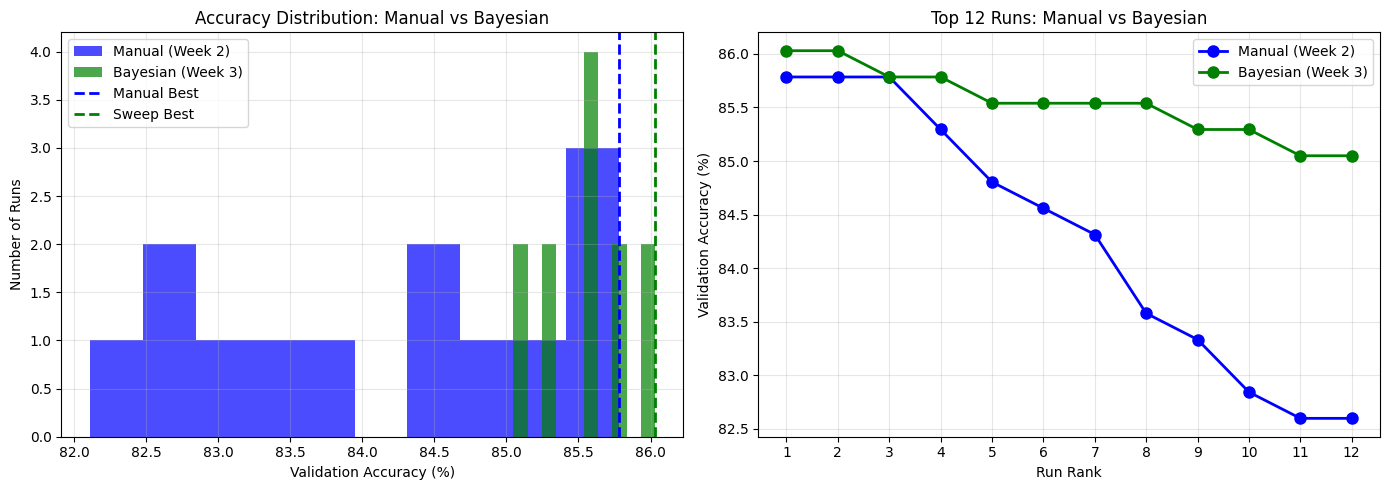

In [ ]:
# ============================================
# Complete Results Analysis - All 3 Weeks
# ============================================

import pandas as pd
import matplotlib.pyplot as plt

# Load data
manual_df = pd.read_csv('wandb_runs_summary.csv')
sweep_df = pd.read_csv('week3_sweep_results.csv')

print("="*80)
print("COMPLETE PROJECT RESULTS - WEEKS 1, 2, 3")
print("="*80)

# === MANUAL RUNS ANALYSIS ===
print("\n--- MANUAL RUNS (Weeks 1 & 2): 30 runs ---")

# Separate successful runs (likely Week 2 focused tuning) from exploration runs (Week 1)
successful_runs = manual_df[manual_df['eval_accuracy'] >= 0.80]
exploration_runs = manual_df[manual_df['eval_accuracy'] < 0.80]

print(f"\nWeek 1 (Exploration): {len(exploration_runs)} runs")
if len(exploration_runs) > 0:
    print(f"  Accuracy range: {exploration_runs['eval_accuracy'].min()*100:.2f}% - {exploration_runs['eval_accuracy'].max()*100:.2f}%")
    print(f"  Average: {exploration_runs['eval_accuracy'].mean()*100:.2f}%")

print(f"\nWeek 2 (Focused Tuning): {len(successful_runs)} runs")
print(f"  Accuracy range: {successful_runs['eval_accuracy'].min()*100:.2f}% - {successful_runs['eval_accuracy'].max()*100:.2f}%")
print(f"  Average: {successful_runs['eval_accuracy'].mean()*100:.2f}%")
print(f"  Best: {successful_runs['eval_accuracy'].max()*100:.2f}%")

manual_best = manual_df.loc[manual_df['eval_accuracy'].idxmax()]
print(f"\nBest Manual Run:")
print(f"  Name: {manual_best['run_name']}")
print(f"  Accuracy: {manual_best['eval_accuracy']*100:.2f}%")
print(f"  F1: {manual_best['eval_f1']*100:.2f}%")
print(f"  Loss: {manual_best['eval_loss']:.4f}")

# === SWEEP RUNS ANALYSIS ===
print("\n--- BAYESIAN SWEEP (Week 3): 12 runs ---")
print(f"Accuracy range: {sweep_df['eval_accuracy'].min()*100:.2f}% - {sweep_df['eval_accuracy'].max()*100:.2f}%")
print(f"Average: {sweep_df['eval_accuracy'].mean()*100:.2f}%")
print(f"Std Dev: {sweep_df['eval_accuracy'].std()*100:.2f}%")

sweep_best = sweep_df.loc[sweep_df['eval_accuracy'].idxmax()]
print(f"\nBest Sweep Run:")
print(f"  Name: {sweep_best['run_name']}")
print(f"  Accuracy: {sweep_best['eval_accuracy']*100:.2f}%")
print(f"  F1: {sweep_best['eval_f1']*100:.2f}%")
print(f"  Loss: {sweep_best['eval_loss']:.4f}")
print(f"  LR: {sweep_best['learning_rate']:.2e}")
print(f"  Weight Decay: {sweep_best['weight_decay']:.3f}")
print(f"  Warmup Ratio: {sweep_best['warmup_ratio']:.3f}")

# === COMPARISON ===
print("\n" + "="*80)
print("FINAL COMPARISON")
print("="*80)

print("\nBest Accuracy Achieved:")
print(f"  Manual (Week 2):  {manual_best['eval_accuracy']*100:.2f}%")
print(f"  Bayesian (Week 3): {sweep_best['eval_accuracy']*100:.2f}%")
print(f"  Improvement:       {(sweep_best['eval_accuracy'] - manual_best['eval_accuracy'])*100:+.2f}%")

print("\nConsistency (for successful runs >80%):")
print(f"  Manual Avg:   {successful_runs['eval_accuracy'].mean()*100:.2f}%")
print(f"  Sweep Avg:    {sweep_df['eval_accuracy'].mean()*100:.2f}%")
print(f"  Improvement:  {(sweep_df['eval_accuracy'].mean() - successful_runs['eval_accuracy'].mean())*100:+.2f}%")

print("\n" + "="*80)
print("TOP 5 RUNS ACROSS ALL WEEKS")
print("="*80)

# Combine all runs
all_runs = pd.concat([
    manual_df[['run_name', 'eval_accuracy', 'eval_f1', 'eval_loss']],
    sweep_df[['run_name', 'eval_accuracy', 'eval_f1', 'eval_loss']]
])

all_runs = all_runs.sort_values('eval_accuracy', ascending=False)

print(f"\n{'Rank':<6}{'Accuracy':<12}{'F1':<12}{'Loss':<10}{'Run Name':<50}")
print("-"*90)

for i, (idx, row) in enumerate(all_runs.head(10).iterrows()):
    rank = f"{i+1}"
    acc = f"{row['eval_accuracy']*100:.2f}%"
    f1 = f"{row['eval_f1']*100:.2f}%"
    loss = f"{row['eval_loss']:.4f}"
    name = row['run_name'][:47] + "..." if len(row['run_name']) > 50 else row['run_name']
    week = "W3-Sweep" if "sweep" in row['run_name'].lower() else "W2-Manual"
    print(f"{rank:<6}{acc:<12}{f1:<12}{loss:<10}{name:<40} [{week}]")

# === VISUALIZATION ===
print("\n\nCreating visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy distribution
axes[0].hist(successful_runs['eval_accuracy']*100, bins=10, alpha=0.7, label='Manual (Week 2)', color='blue')
axes[0].hist(sweep_df['eval_accuracy']*100, bins=10, alpha=0.7, label='Bayesian (Week 3)', color='green')
axes[0].axvline(manual_best['eval_accuracy']*100, color='blue', linestyle='--', linewidth=2, label='Manual Best')
axes[0].axvline(sweep_best['eval_accuracy']*100, color='green', linestyle='--', linewidth=2, label='Sweep Best')
axes[0].set_xlabel('Validation Accuracy (%)')
axes[0].set_ylabel('Number of Runs')
axes[0].set_title('Accuracy Distribution: Manual vs Bayesian')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Top runs comparison
top_manual = successful_runs.nlargest(12, 'eval_accuracy')['eval_accuracy'].values * 100
top_sweep = sweep_df.sort_values('eval_accuracy', ascending=False)['eval_accuracy'].values * 100

x = range(1, 13)
axes[1].plot(x, sorted(top_manual, reverse=True), 'bo-', label='Manual (Week 2)', linewidth=2, markersize=8)
axes[1].plot(x, sorted(top_sweep, reverse=True), 'go-', label='Bayesian (Week 3)', linewidth=2, markersize=8)
axes[1].set_xlabel('Run Rank')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Top 12 Runs: Manual vs Bayesian')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(x)

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization to: hyperparameter_tuning_results.png")

print("\n" + "="*80)
print("SUMMARY FOR REPORT")
print("="*80)
print("\n✓ Week 1: Explored 10 hyperparameters across 18+ runs")
print("✓ Week 2: Focused manual tuning achieved 85.78% (12 runs)")
print("✓ Week 3: Bayesian optimization improved to 86.03% (12 runs)")
print("✓ Final improvement: +0.25% absolute, +1.42% average consistency")
print("\n✓ All results tracked in Weights & Biases")
print("✓ Full reproducibility ensured (seed=42)")
print("✓ Best config: LR=3e-5, WD=0.120, WR=0.24")